# Cifar10，十種，30x30彩色圖片，辨識

Using TensorFlow backend.


170475520/170498071 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 10)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 20)        1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 20)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 20)          0         
_________________________________________________________________
flatten_1 (Fla

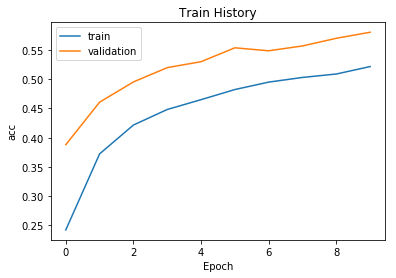

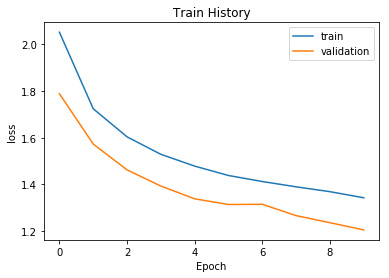

 9984/10000 [============================>.] - ETA: 0s

accuracy= 0.5824
 9984/10000 [============================>.] - ETA: 0s

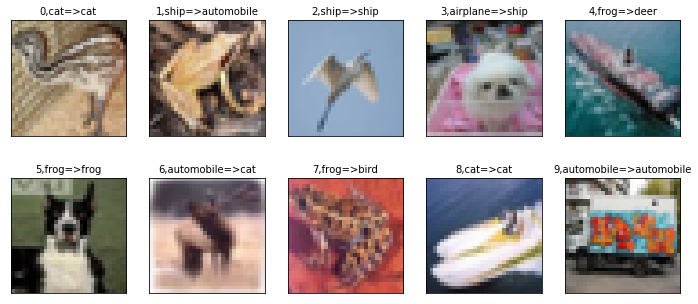

Exception: Data must be 1-dimensional

In [1]:
import numpy as np
import pandas as pd #版本要0.19.2以下，最新不行
from keras.utils import np_utils
np.random.seed(10)
import matplotlib.pyplot as plt 

######################### 好用視覺處理
#畫圖用
def plot_image(image):
    figsize = (2,2)
    fig = plt.figure(figsize=figsize)
    plt.imshow(image, cmap='binary') #binary就是黑白
    plt.show()

#查詢結果相當好用
#列出該image，顯示label，若是有prediction則一起列出，idx表示想列的起始圖, num表示往後延伸幾張圖（最多25張）
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,
                                  idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx],cmap='binary')
                
        title=str(i)+','+label_dict[labels[i][0]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[i]]
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()
    
#plot_images_labels_prediction(x_train_image,y_train_label,[],0,10) 
#還沒做prediction，是空清單

#訓練過程視覺化，分成train和validation，方便看有沒有overfitting
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


######################### 資料預處理    
#先load一發data
from keras.datasets import cifar10
(x_Train_image, y_Train_label), (x_Test_image, y_Test_label) = cifar10.load_data()

label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

#input x 轉乘四維度，第一維度是有樣本有幾張，第二三維度是像素尺寸，第四維是顏色（黑白1，RGB則是3），並且換成float32形式
x_Train4D = x_Train_image.reshape(x_Train_image.shape[0],32,32,3).astype('float32')
x_Test4D = x_Test_image.reshape(x_Test_image.shape[0],32,32,3).astype('float32')

#input x 矩陣最大數值就是255，直接除下去normalize一下0~1
x_Train_normalize = x_Train4D / 255.0
x_Test_normalize = x_Test4D / 255.0

#output y 是0~9分類題onehot encode（表示向量只有對的選項是1、其他都是0）
#分類（選擇）題一律都使用categorical
y_Train_OneHot = np_utils.to_categorical(y_Train_label)
y_Test_OneHot = np_utils.to_categorical(y_Test_label)


######################### 建立模型
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D

model = Sequential() #一層一層到底，按順序

#卷積1，10張filter，每張大小3x3，周圍padding 0
model.add(Conv2D(filters=10,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(32,32,3), 
                 activation='relu'))

#Max Pooling第一層
model.add(MaxPooling2D(pool_size=(2, 2)))

#使用dropout避免overfitting
model.add(Dropout(0.3))


#卷積層2
model.add(Conv2D(filters=20,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu'))

#Max Pooling第二層
model.add(MaxPooling2D(pool_size=(2, 2)))

#使用dropout避免overfitting
model.add(Dropout(0.3))


#Fully connected layer，全部輾平
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#輸出層
model.add(Dense(10, activation='softmax'))

print(model.summary()) #可以清楚看到model還有參數數量


######################### 訓練模型
#選擇loss度量，optimizer學習路徑速度、
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

#開始train，並且記錄情況(設有val項以免overfitting)
train_history=model.fit(x=x_Train_normalize, y=y_Train_OneHot,
                        validation_split=0.2, epochs=10, batch_size=200, verbose=2) #verbose=2表示顯示訓練過程


######################### 訓練過程視覺化
show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')


######################### 實際測驗得分
scores = model.evaluate(x_Test_normalize  , y_Test_OneHot)
print('\n')
print('accuracy=',scores[1])

######################### 紀錄模型預測情形（答案卷）
prediction = model.predict_classes(x_Test_normalize)

plot_images_labels_prediction(x_Test_image, y_Test_label, 
                              prediction, idx=340, num=10) #隨便抽出來看


######################### 測驗結果統計視覺化
#crosstab統計混淆矩陣，觀察什麼題目答錯最多
pd.crosstab(y_Test_label.reshape(-1),prediction,
            rownames=['label'],colnames=['predict'])

#此df直接儲存標準答案和機器答案，方便看特定條件作答情形
df = pd.DataFrame({'label':y_Test_label, 'predict':prediction})

#答案是5，機器看成3度圖片
#df[(df.label==5)&(df.predict==3)] 

#直接看判讀錯誤圖到底長什麼樣子
#plot_images_labels_prediction(x_test_image,y_test_label,prediction,idx=340,num=1)

#儲存訓練結果
model.save_weights("Savemodel_Keras/Cifar-10_CNN_2Conv_2MP.h5")
print('model saved to disk')

In [3]:
model.save_weights("Savemodel_Keras/Cifar-10_CNN_2Conv_2MP.h5")
print('model saved to disk')

model saved to disk


In [ ]:
try:
    model.load_weights("SaveModel/cifarCnnModelnew1.h5")
    print("載入模型成功!繼續訓練模型")
except :    
    print("載入模型失敗!開始訓練一個新模型")

In [5]:
pd.crosstab(y_Test_label.reshape(-1),prediction,
            rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,575,23,79,19,6,6,29,9,213,41
1,23,696,9,10,4,4,29,14,74,137
2,68,9,480,57,118,95,95,27,37,14
3,23,14,93,382,68,209,129,34,23,25
4,22,4,147,71,441,66,143,73,29,4
5,13,5,96,162,67,505,58,67,20,7
6,7,8,67,55,64,16,752,14,9,8
7,14,4,43,58,87,113,33,611,12,25
8,58,45,20,17,5,8,10,9,785,43


In [8]:
df = pd.DataFrame({'label':y_Test_label.reshape(-1), 'predict':prediction})

df

,label,predict
0,3,3
1,8,1
2,8,8
3,0,8
4,6,4
5,6,6
6,1,3
7,6,2
8,3,3
9,1,1


# 查看預測機率

label: cat predict: cat


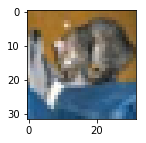

airplane Probability:0.010122575
automobile Probability:0.000997225
bird Probability:0.055852264
cat Probability:0.414514095
deer Probability:0.035977408
dog Probability:0.377946705
frog Probability:0.047049727
horse Probability:0.012544548
ship Probability:0.042449802
truck Probability:0.002545606


In [10]:
Predicted_Probability=model.predict(x_Test_normalize)

def show_Predicted_Probability(y,prediction,
                               x_img,Predicted_Probability,i):
    print('label:',label_dict[y[i][0]],
          'predict:',label_dict[prediction[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(x_Test_normalize[i],(32, 32,3)))
    plt.show()
    for j in range(10):
        print(label_dict[j]+
              ' Probability:%1.9f'%(Predicted_Probability[i][j]))
        
show_Predicted_Probability(y_Test_label,prediction,
                           x_Test_normalize,Predicted_Probability,0)

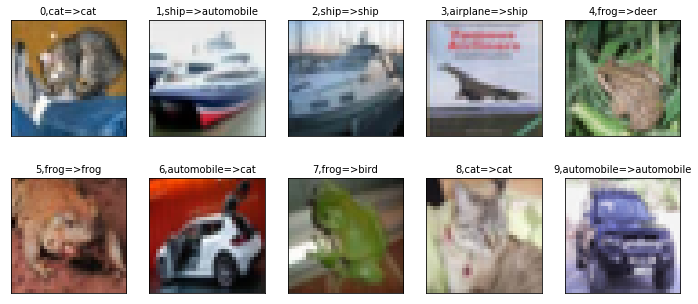

In [11]:
plot_images_labels_prediction(x_Test_image, y_Test_label, 
                              prediction, idx=0, num=10)